In [9]:
%matplotlib inline
import numpy as np
import pylab as pl
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.interpolate
import random

from numpy import random
import matplotlib.image as mpimg
from scipy.optimize import curve_fit

## Formula that describes the ellipse on the Armenteros-odolanski plot.
def func(x, m_Ks, m_pi):
    return np.sqrt(abs((-m_Ks)**2*(1.-x**2)/4.-m_pi**2))

In [10]:
data=np.loadtxt("KS.dat") #loading the actual collision data
data=data[(np.arange(data.shape[0])[data[:,1]>115.5]),:] #cutting off the Lambdas and leaving only KS

realdata=data[:,(2,1)] #extracting just the pt and alpha from the real collision data
realdata=np.array(realdata)

In [86]:
nps=1 #Number of pseudo datasets.

ngi=100 #Number of iterations for calculating the Theil index for the same mass pair.

kaon=(550-450)*np.random.rand(nps)+450
pion=(200-100)*np.random.rand(nps)+100

y_binnum=500 #number of bins along the y-axis
x_binnum=y_binnum #number of bins along the x-axis

#Binning the real data.
StartMatrix,ax,ay=np.histogram2d(realdata[:,1],realdata[:,0],x_binnum,range=[[0,350],[-1,1]])

Theil=np.zeros((nps,3)) #[Theil index,Kaon mass,pion mass]

# Creating the histogram of the real data.
a = realdata[:,0]
counts, bins = np.histogram(a, bins=100, density=True)
cum_counts = np.cumsum(counts)
bin_widths = (bins[1:] - bins[:-1])

# Interpolating the histogram and finding the distribution.
x = cum_counts*bin_widths
y = bins[1:]
inverse_density_function = scipy.interpolate.interp1d(x, y)
    
for p in range(nps): #going trough the pseudo datasets
    
    #Generating alpha values using the same distribution.
    alpha=inverse_density_function( random.uniform( x[0], x[-1],[ngi,data.shape[0]]) )
    pt=func(alpha,kaon[p],pion[p]) #finding the y-coordinate of the bin where an event belongs
    TheilGaus=np.zeros((ngi))
    for jj in range(ngi):
        matrix,ax,ay=np.histogram2d(pt[jj],alpha[jj],x_binnum,range=[[0,350],[-1,1]])
        Matrix=matrix + StartMatrix+1

        T=0
        events=np.asarray(Matrix).reshape(-1)
        mean=np.mean(events)

        #calculating the Theil index

        events1=events
        Ev=events*np.log(events1/mean)
        T=np.sum(Ev)/mean
        T/=Ev.shape[0]*np.log(Ev.shape[0])

        TheilGaus[jj]=T

    mu, std = norm.fit(TheilGaus)
    Theil[p]=[mu,kaon[p],pion[p]] 
    
#np.savetxt('Theilindex-v5.0-run1-bin500x500-1000.txt',Theil, delimiter=',')    

Translation [ 493.90487144  135.12135434]
Rotation matrix [[ 0.7768821 -0.6296461]
 [ 0.6296461  0.7768821]]
Radii [ 70.1478521    5.32367861]


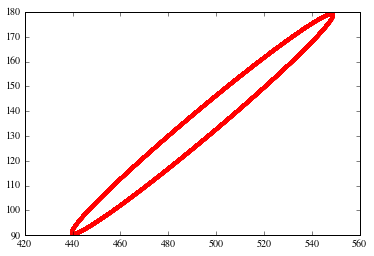

In [104]:
#Loading the dots from the run.

TheilGen=np.loadtxt('Theilindex-v5.0-run1-bin500x500-15000-1.txt',delimiter=',')
TheilGen=TheilGen[TheilGen[:, 0].argsort()[::-1]] #Sorting the dots by the Theil index.
TheilGen=TheilGen[:TheilGen.shape[0]/10] #Extracting the 10% dots with the highest Theil index.

###
### Drawing an ellipse around the top 10% dots.
###

ellipsedata=TheilGen[:,[1,2]].T

# Step 1: center the data to get the translation vector.
print 'Translation', ellipsedata.mean(axis=1)
[mean_x,mean_y ]=ellipsedata.mean(axis=1)
ellipsedata -= np.reshape(ellipsedata.mean(axis=1), (2, 1))

# Step 2: perform PCA to find rotation matrix.
scatter = np.dot(ellipsedata, ellipsedata.T)
eigenvalues, transform = np.linalg.eig(scatter)
print 'Rotation matrix', transform

# Step 3: Rotate back the data and compute radii.
# You can also get the radii from smaller to bigger
# with 2 / numpy.sqrt(eigenvalues)
rotated = np.dot(np.linalg.inv(transform), ellipsedata)
print 'Radii', 2 * rotated.std(axis=1)
[a, b]= 2 * rotated.std(axis=1)

# Drawng the 10% ellipse
ex = np.linspace(0,a,10000)
ey =np.array(  b *np.sqrt(1-(ex / a)**2 ) )
ex=np.array([np.concatenate((ex,ex,-ex,-ex))])
ey=np.array([np.concatenate((ey,-ey,ey,-ey),axis=1)])
ellipse=np.concatenate((ex,ey))
transform=np.array(transform)
ellipse=np.dot(transform, ellipse)
ellipse[0] += mean_x
ellipse[1] += mean_y
plt.plot(ellipse[0],ellipse[1],'.r')

#Generating new N pseudo datasets in the ellipse area for the next iteration.
N=1000 #Number of new pseudo datasets
n=0
Ellipse_x=[]
Ellipse_y=[]
while n<N:
    X =np.random.uniform(-a,a)
    Y =np.random.uniform(-b,b)
    d = (X / a) ** 2 + (Y / b) ** 2
    if d<1:
        Ellipse_x=np.append(Ellipse_x,X)
        Ellipse_y=np.append(Ellipse_y,Y)
        n=n+1
Ellipse_x=np.array([Ellipse_x])
Ellipse_y=np.array([Ellipse_y])

Ellipse = np.concatenate((Ellipse_x, Ellipse_y),axis=0)

Ellipse = np.dot(transform, Ellipse)
Ellipse[0, :] += mean_x
Ellipse[1, :] += mean_y

NameError: name 'ellipse' is not defined

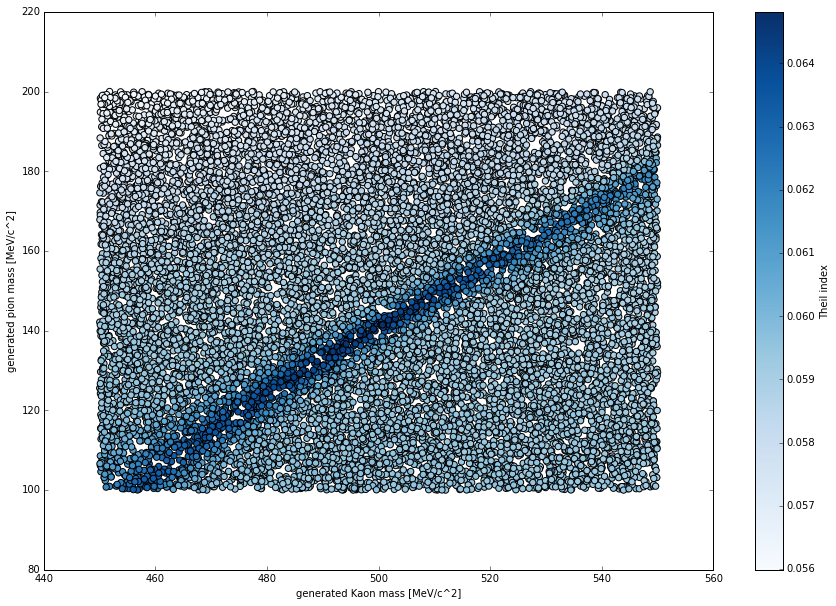

In [5]:
Theil=np.loadtxt('Theilindex-v5.0-run1-bin500x500-15000-1.txt',delimiter=',')
#Theil=np.loadtxt("AAAAA.txt",delimiter=',')
#Theil=Theil[Theil[:, 0].argsort()[::-1]]
#Theil=Theil[:1000]

%matplotlib inline
from matplotlib import pyplot as plt

x = Theil[:,1]
y = Theil[:,2]
z = Theil[:,0]
color = [str(item/255.) for item in z]

plt.figure(figsize=(15,10))
plt.scatter(x, y, c=z, s=40, cmap=plt.cm.Blues)
plt.xlabel('generated Kaon mass [MeV/c^2]')
plt.ylabel('generated pion mass [MeV/c^2]')
cbar=plt.colorbar()
cbar.set_label('Theil index')
plt.plot(ellipse[0],ellipse[1],'.r') #Potting the red ellipse.
#plt.plot(Ellipse[0],Ellipse[1],'.r') #Potting the red ellipse.

#savefig("run1-bin100x100.png")


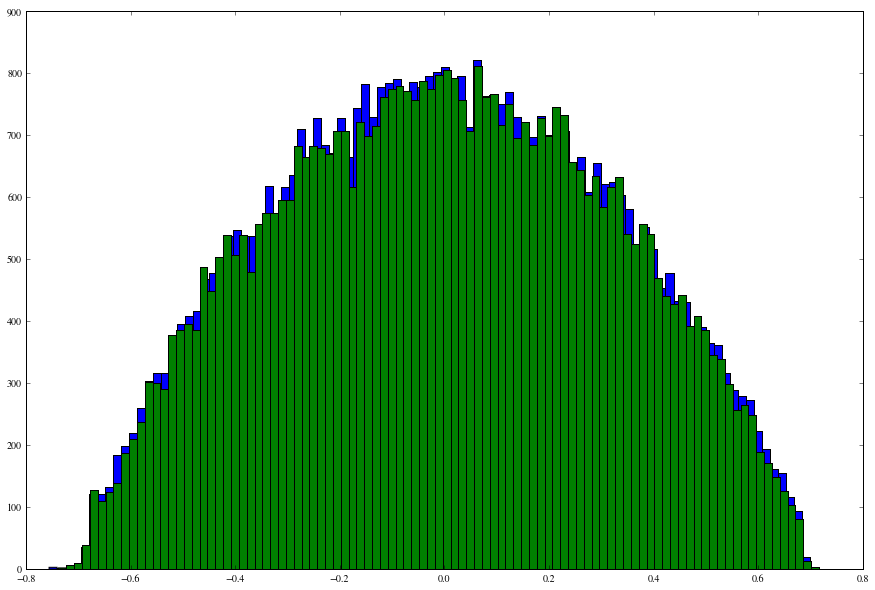

In [118]:
# create some normally distributed values and make a histogram
a = realdata[:,0]
counts, bins = np.histogram(a, bins=100, density=True)
cum_counts = np.cumsum(counts)
bin_widths = (bins[1:] - bins[:-1])

# generate more values with same distribution
x = cum_counts*bin_widths
y = bins[1:]
inverse_density_function = scipy.interpolate.interp1d(x, y)
b = np.zeros(data.shape[0])
for i in range(len( b )):
    u = random.uniform( x[0], x[-1] )
    b[i] = inverse_density_function( u )

# plot both
plt.figure(figsize=(15,10))
plt.hist(a, 100) 
plt.hist(b, 100)
plt.savefig('alpha-gausian-v5.0.png')

In [61]:
counts

array([ 0.00410713,  0.00273808,  0.00273808,  0.00273808,  0.04791647,
        0.16702313,  0.16702313,  0.1820826 ,  0.25190374,  0.27107033,
        0.29982022,  0.35595094,  0.41481975,  0.4326173 ,  0.43398634,
        0.51339078,  0.54077162,  0.55856917,  0.5695215 ,  0.64071169,
        0.65303307,  0.67219966,  0.7351756 ,  0.74886602,  0.7351756 ,
        0.73654464,  0.73380655,  0.846068  ,  0.78446111,  0.84469896,
        0.87071076,  0.97201988,  0.8720798 ,  0.99666263,  0.93642478,
        0.91862723,  0.99666263,  0.90904394,  1.01856731,  1.07059091,
        0.99803167,  1.06511474,  1.07332899,  1.08154324,  1.03362677,
        1.07606707,  1.06511474,  1.08975749,  1.09797175,  1.10892408,
        1.06648378,  1.08838845,  0.976127  ,  1.12535259,  1.04457911,
        1.04731719,  1.02678156,  1.05279336,  0.99803167,  0.96928179,
        0.95422233,  1.00076976,  0.95832945,  0.99118646,  0.96654371,
        0.8980916 ,  0.91041298,  0.83374663,  0.89672256,  0.85

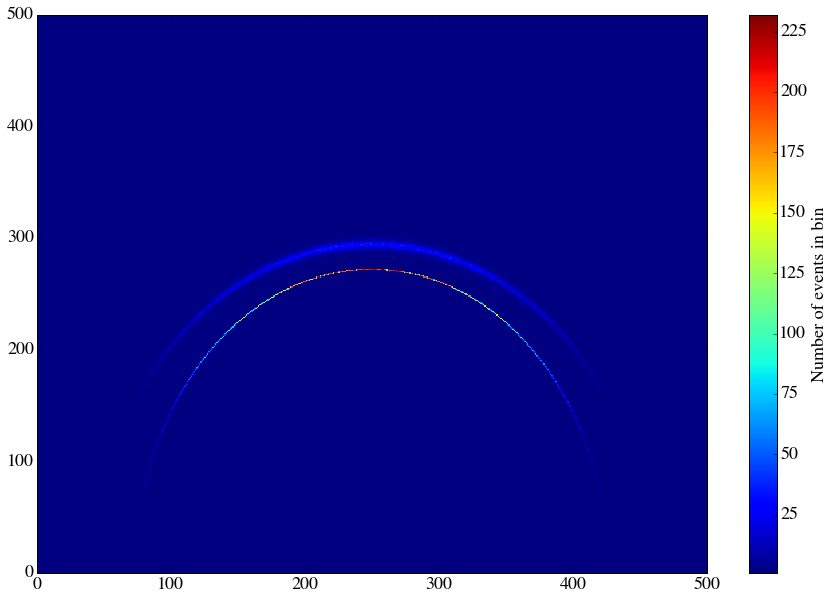

In [63]:
import matplotlib
%matplotlib inline
#Matrix=np.loadtxt("AAAAA-new-mat.txt",delimiter=',')

matplotlib.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
plt.figure(figsize=(15,10))

plt.pcolor(Matrix)
cbar=plt.colorbar()
cbar.set_label('Number of events in bin')

#plt.savefig("AAAAA-new.png")

In [94]:
T3=np.loadtxt('Theilindex-v5.0-run1-bin500x500-1000_183.txt',delimiter=',')
T4=np.loadtxt('Theilindex-v5.0-run1-bin500x500-1000_184.txt',delimiter=',')
T5=np.loadtxt('Theilindex-v5.0-run1-bin500x500-1000_188.txt',delimiter=',')
T2=np.loadtxt('Theilindex-v5.0-run1-bin500x500-1000_189.txt',delimiter=',')
T8=np.loadtxt('Theilindex-v5.0-run1-bin500x500-1000_190.txt',delimiter=',')
T9=np.loadtxt('Theilindex-v5.0-run1-bin500x500-1000_191.txt',delimiter=',')
T10=np.loadtxt('Theilindex-v5.0-run1-bin500x500-1000_192.txt',delimiter=',')
T6=np.loadtxt('Theilindex-v5.0-run1-bin500x500-1000_193.txt',delimiter=',')
T7=np.loadtxt('Theilindex-v5.0-run1-bin500x500-1000_194.txt',delimiter=',')
T1=np.loadtxt('Theilindex-v5.0-run1-bin500x500-1000_195.txt',delimiter=',')

THEIL=np.concatenate((T1,T2,T3,T4,T5,T6,T7,T8,T9,T10),axis=0)
np.savetxt('Theilindex-v5.0-run1-bin500x500-1000-17.txt',THEIL, delimiter=',')


In [96]:
T1=np.loadtxt('Theilindex-v5.0-run1-bin500x500-1000-11.txt',delimiter=',')
T2=np.loadtxt('Theilindex-v5.0-run1-bin500x500-1000-12.txt',delimiter=',')
T3=np.loadtxt('Theilindex-v5.0-run1-bin500x500-1000-13.txt',delimiter=',')
T4=np.loadtxt('Theilindex-v5.0-run1-bin500x500-1000-14.txt',delimiter=',')
T5=np.loadtxt('Theilindex-v5.0-run1-bin500x500-1000-15.txt',delimiter=',')
T6=np.loadtxt('Theilindex-v5.0-run1-bin500x500-10000-1.txt',delimiter=',')

THEIL=np.concatenate((T1,T2,T3,T4,T5,T6),axis=0)
np.savetxt('Theilindex-v5.0-run1-bin500x500-15000-1.txt',THEIL, delimiter=',')


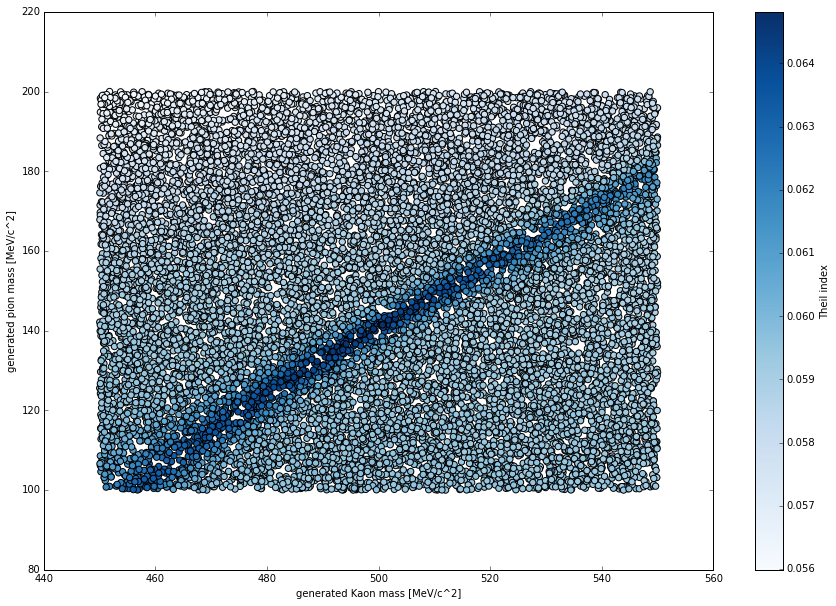

In [4]:
Theil=np.loadtxt('Theilindex-v5.0-run3-bin500x500-96500.txt',delimiter=',')
#Theil=np.loadtxt("AAAAA.txt",delimiter=',')
#Theil=Theil[Theil[:, 0].argsort()[::-1]]
#Theil=Theil[:1500]

%matplotlib inline
from matplotlib import pyplot as plt

x = Theil[:,1]
y = Theil[:,2]
z = Theil[:,0]
color = [str(item/255.) for item in z]

plt.figure(figsize=(15,10))
plt.scatter(x, y, c=z, s=40, cmap=plt.cm.Blues)
plt.xlabel('generated Kaon mass [MeV/c^2]')
plt.ylabel('generated pion mass [MeV/c^2]')
cbar=plt.colorbar()
cbar.set_label('Theil index')
#plt.plot(ellipse[0],ellipse[1],'.r') #Potting the red ellipse.
#plt.plot(Ellipse[0],Ellipse[1],'.r') #Potting the red ellipse.

plt.savefig("Theilindex-v5.0-run1-bin500x500-15000-1.png")


 mean : 0.062760, std : 0.000033


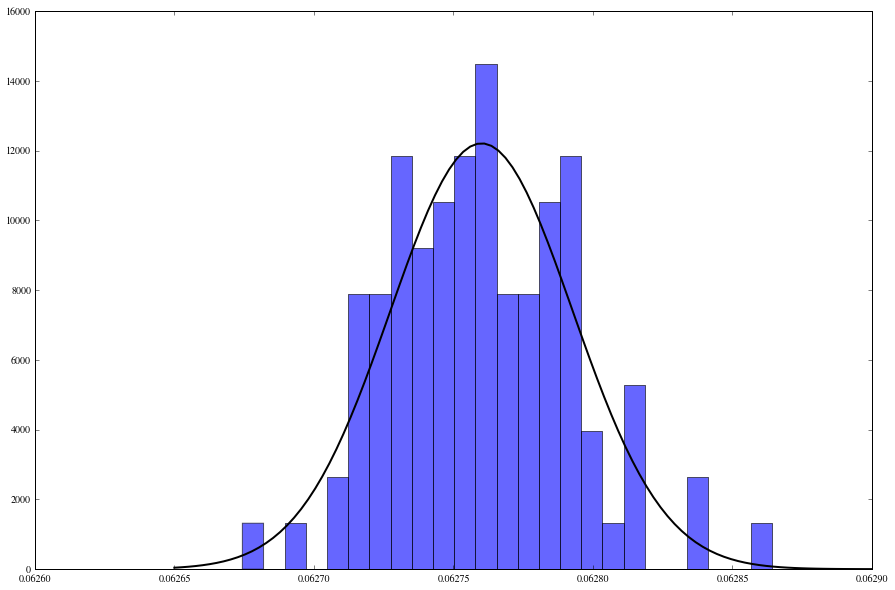

In [112]:
Data = TheilGaus
plt.figure(figsize=(15,10))
# Fit a normal distribution to the data:
mu, std = norm.fit(Data)

# Plot the histogram.
plt.hist(Data, bins=25, normed=True, alpha=0.6,label='mean="+str(mu)+", std="+str(std)')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
#title = "Fit results: mu = %f,  std = %f" % (mu, std)
#plt.title(title)
print(" mean : %f, std : %f" % (mu, std))

plt.savefig('TheilGaus-v5.0-bin500.png')

array([[  5.89499812e-02,   4.65357794e+02,   1.52038563e+02],
       [  5.88636741e-02,   4.89289627e+02,   1.67591876e+02],
       [  5.88293616e-02,   4.73460299e+02,   1.59151874e+02],
       ..., 
       [  5.90290699e-02,   5.46591456e+02,   1.47824648e+02],
       [  5.92997980e-02,   4.89614947e+02,   1.45122349e+02],
       [  5.93368401e-02,   4.62212684e+02,   1.34366767e+02]])